<a href="https://colab.research.google.com/github/Vladislavdovenko/Tragical/blob/master/RegressionTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сначала следует импортировать все необходимые зависимости и провести первоначальные настройки
Классические библиотеки для ML которые скорее всего понадобятся - Numpy, Pandas, Sklearn, Matplotlib, Tensorflow, Keras

In [0]:
# import modules
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (25, 10)  # Размер картинок

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

###Подключить Google диск

In [11]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Директория на Google-диск куда будет сохранена модель и все препроцессоры

In [0]:
PATH = ''

# После импортируйте набор данных (т.е. датасет) в проект. 
Это можно сделать разными способами:
  - с помощью уже готовых утилит датасета:

    `(x_train, y_train), (x_test, y_test) = tensorflow.keras.dataset.fashion_mnist.load_data() `
  - получая текстом с сайта:

    `df = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/master/doc/data/tips.csv')`
    
и т.д.

В первом случае(этот датасет не для регрессии, просто как пример) данные уже разделены на выборки, во втором необходимо это сделать самому

### Загрузите данные

In [171]:
df = pd.read_csv('https://raw.githubusercontent.com/pandas-dev/pandas/master/doc/data/tips.csv')
type(df)  # expected pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

#Взгляните на ваши данные
Понимание того как выглядит и как устроены ващи данные поможет вам понять как решить задачу

In [0]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [0]:
df

,total_bill,tip,sex,smoker,day,time,size,enc_smoker
0,16.99,1.01,0,0,2,0,2,1
1,10.34,1.66,1,0,2,0,3,1
2,21.01,3.50,1,0,2,0,3,1
3,23.68,3.31,1,0,2,0,2,1
4,24.59,3.61,0,0,2,0,4,1
...,...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,0,3,1
240,27.18,2.00,0,1,1,0,2,0
241,22.67,2.00,1,1,1,0,2,0
242,17.82,1.75,1,0,1,0,2,1


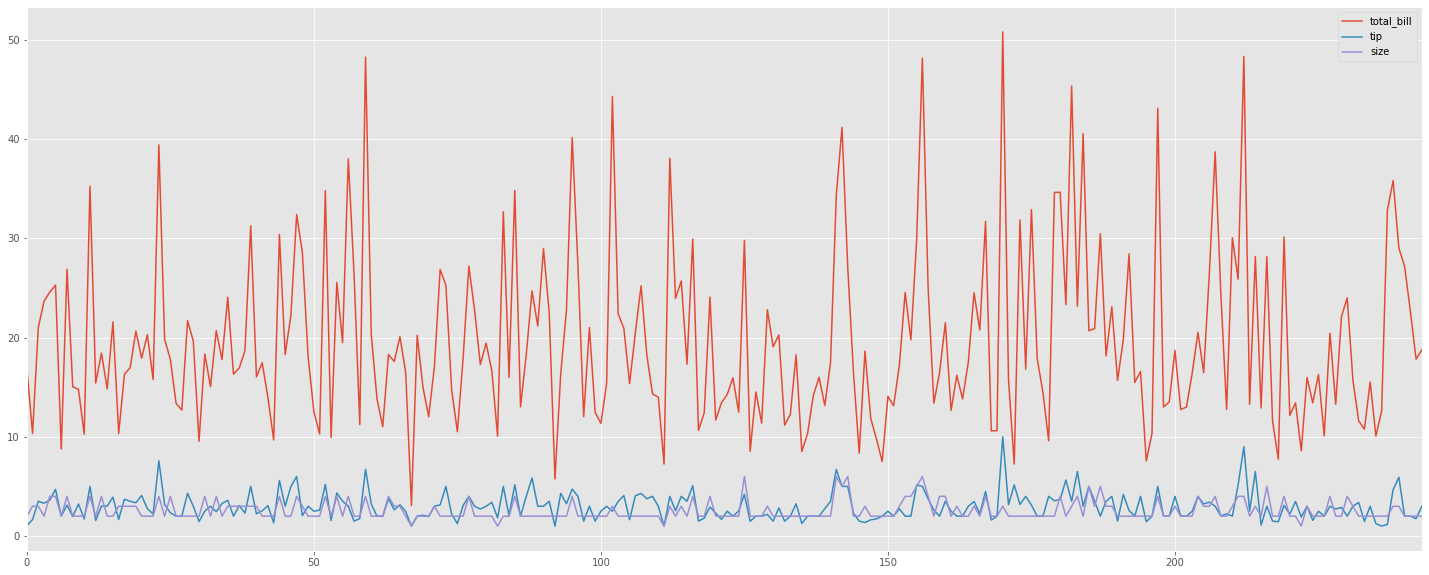

In [0]:
df.plot()

Как видно из графика - искомая метка total_bill апроксимируется двумя другими графиками, только в другом диапазоне и не всегда точно. Однако у нас есть еще и категориальные данные. Попробуйте сделать визуализацию данных повторно, после того как обработаете текстовые данные и нормализируете датасет

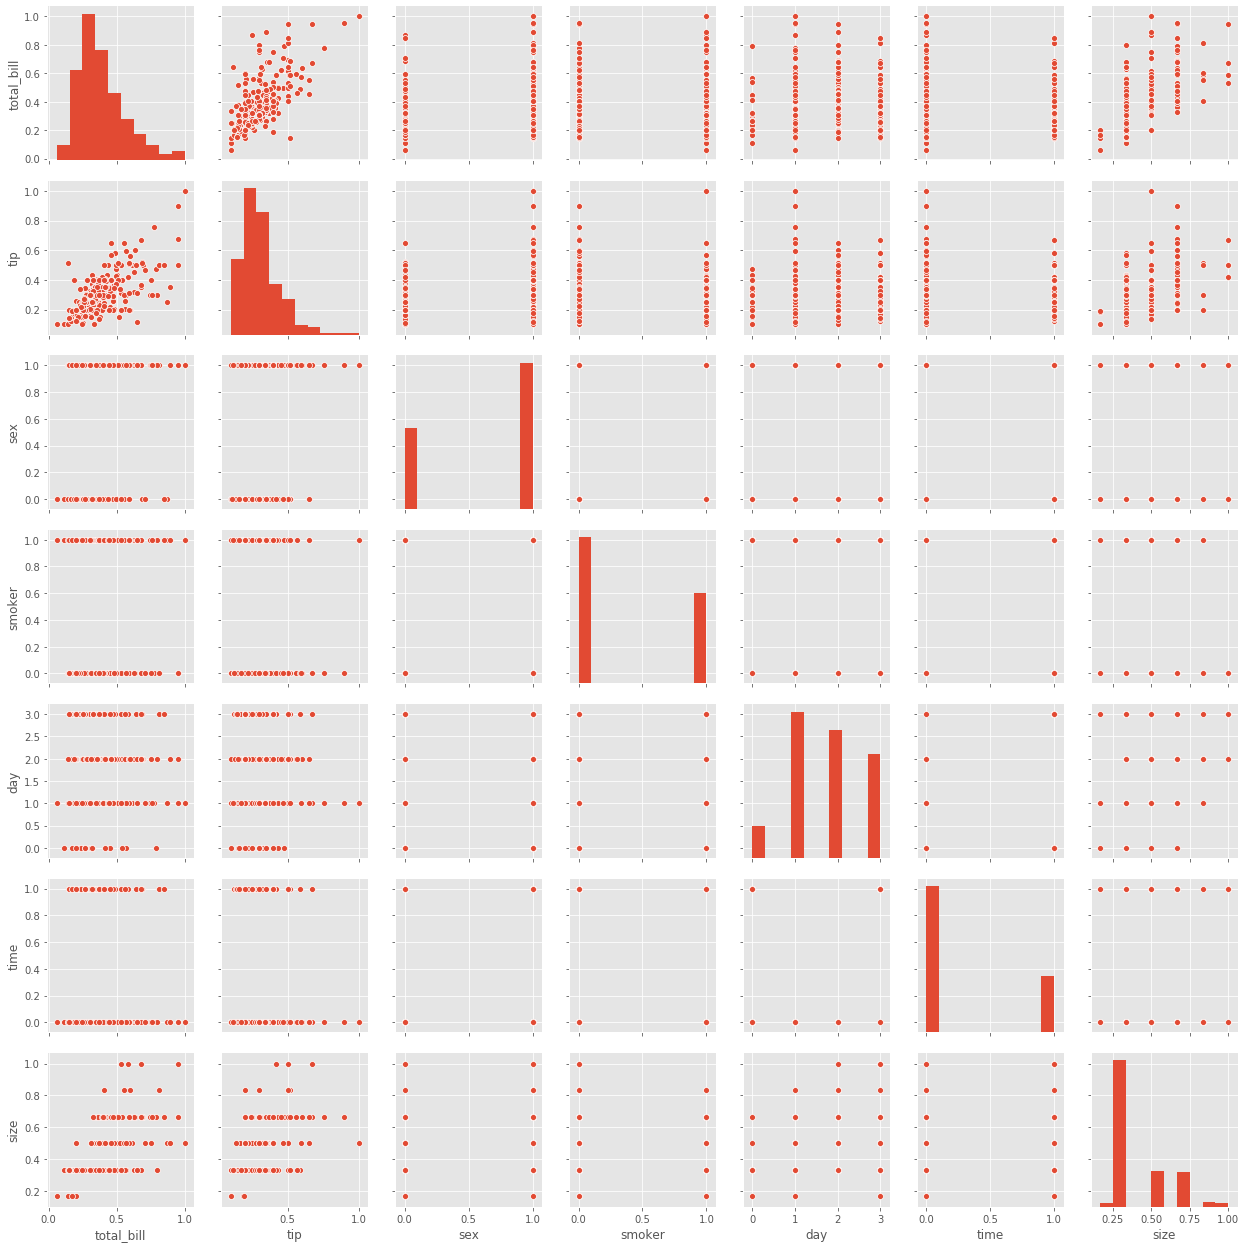

In [0]:
sns.pairplot(df);

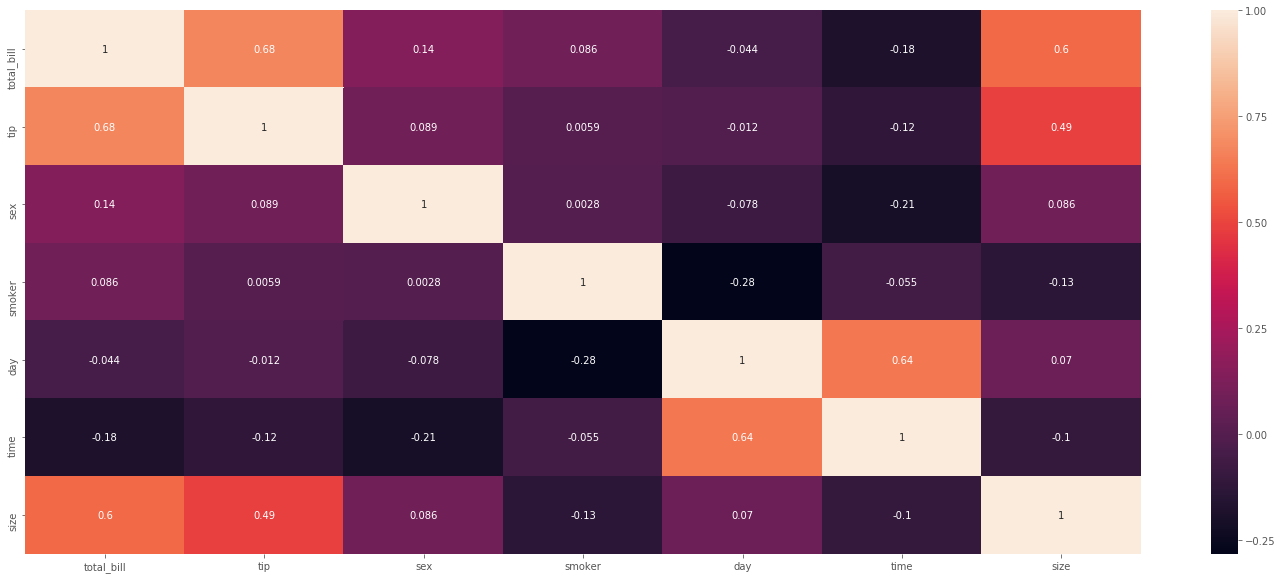

In [0]:
sns.heatmap(df.corr(), annot=True)

На этих графиках можно увидеть попарные соотношения данных столбцов друг с другом. Это наглядно подтверждает гипотезу о некоторой апроксимации этих трех столбцов. 
Обязательно повторите визуализацию после того как приведете в нужный вид другие столбцы.

Ищите зависимости в других загруженых датасетах. Понимание того как связаны между собой данные поможет решить проблему, а также обнаружить мусор и шумы в них или необьективные признаки (такие что никак не влияют на результат), если с данными не все порядке.
Успех решения задачи в большей степени зависит от правильно отобранных и обработанных данных.

# Предварительная обработка данных и нормализация
Теперь необходимо представить все данные только в чисельном виде (единственным понятным для алгоритмов используемых в машинном и глубоком обучении).

Ваши категориальные данные необходимо перевести в чисельные дискретные метки. Существует два распространенных подхода - label Encoding и one hot Encoding.

*К примеру, у вас есть столбец с категориальными данными - города. В наборе данных встречаются 3 разных города (Лондон, Нью-Йорк, Киев)
Label encoder закодирует их в числа от 0 до 2 ( Лондон = 0, Нью-Йорк = 1, Киев = 2 ). 
One hot encoder закодирует каждое значение в вектор такой размерности сколько всего есть классов. Т.е. - Лондон - [1,0,0], Нью-Йорк - [0,1,0], Киев - [0,0,1].*

*Второй подход очевидно предпочтительнее, так как все классы равноудаленны один к другому в полученом трехмерном пространстве, label Encoding же со своим одномерным отображением не может этого дать, но может быть полезен в другом случае - при кодировании бинарных меток (таких как да/нет, мужчина/женщина и т.д)* 

Если же у вас нет категориальных данных, то можно сразу перейти к нормализации. 

In [0]:
# Самописный Label Encoder в виде Лямбда функции
df['enc_smoker'] = df['smoker'].apply(lambda x: 0 if x == 'Yes' else 1)
df['enc_smoker'].unique()

array([1, 0])

In [0]:
def Preprocessing(df, cat_cols):  # label Encoding
    print("preproc")
    path_p = '/preps/'
    labelEncoder = preprocessing.LabelEncoder()
    print("encoding")
    for col in cat_cols:
        try:
            df[col] = labelEncoder.fit_transform(df[col])
            np.save(PATH + col + '_classes.npy', labelEncoder.classes_)  # will save your preps
        except Exception as e:
            print(e)
    dataset = pd.DataFrame(df)
    print("finished prepr")

    return dataset

### Запишите столбцы которые вы собираетесь использовать, категориальные столбцы и название искомой метки в разные переменные

In [0]:
label = "total_bill"
all_colons = ["tip", "sex", "smoker", "day", "time", "size"]
category_colons = ["sex", "smoker", "day", "time"]

###Обработайте категориальные данные

In [173]:
df = Preprocessing(df, category_colons)

preproc
encoding
finished prepr


In [0]:
###

###Нормализация
Нормализация - это процесс приведения всех данных к одной размерности к примеру в интервал от 0 до 1. 
Считается что нейросеть лучше обучается в интервале с одной размерностью, но на практике это случается не всегда. 
Попробуйте обучить сеть с нормализированными столбцами и стандартными

In [0]:
for colon in all_colons:
  if colon in category_colons:
    continue
  df[colon] = df[colon]/df[colon].max()

In [0]:
df[label] = df[label]/df[label].max()

###Разбиение датасета

In [0]:
y = df[label]
df = df[all_colons]

x_train, x_test, t_train, t_test = train_test_split(df, y, test_size=0.15, random_state=0)

# Компиляция модели и обучение

###Построение модели
Мы используем полносвязную модель Sequential, в которой каждый нейрон(перцептрон) связан с каждым нейроном следующего слоя. 
Следующая модель содержит 5 уровней Dense (из них один входной и один выходной, который содержит только один нейрон, который и выдает искомый результат), 3 внутренних уровня называются вложенными, их наличие означает *глубокую нейросеть*.

Каждый слой сети (Dense) так же содержит функцию активации, по факту все значения которые проходят через данный слой лежат в диапазоне допустимых значений функции активации. 
Последний слой имеет сигмоидальную функцию активацию, это значит что выходные значения могут быть только в значениях от 0 до 1.**(!)**

*В предыдущих уровня используется функция активации Relu с диапазон от 0 до бесконечности*


**(!)** Попробуйте не нормализировать ваши данные и ограничиться только препроцессингом. В таком случае у вас ошибка(отклонение) при обучении и на тестовой выборке будет порядка 90-100%, так как данные метки в сыром виде лежат от 3 до 50, а функция активации (сигмоида) даст на выходном слое результаты от 0 до 1. 
Вы можете изменить функцию активации выходного слоя на другую с более подходящим диапазоном ( например RELu) и посмотреть на результат. 
В другом варианте вы можете преобразовать ( нормализовать ) данные выходной метки в диапазон от 0 до 1 и тогда сигмоида также даст приемливый результат !

In [0]:
model = Sequential()
model.add(Dense(12, activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(seed=0),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        input_shape=(df.shape[1],)))
model.add(Dense(12, activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(seed=0),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        input_shape=(df.shape[1],)))
model.add(Dense(24, activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(seed=0),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        input_shape=(df.shape[1],)))
model.add(Dense(48, activation="relu",
                        kernel_initializer=keras.initializers.RandomNormal(seed=0),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        input_shape=(df.shape[1],)))
model.add(Dense(1, activation="sigmoid",
                        kernel_initializer=keras.initializers.RandomNormal(seed=0),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        input_shape=(df.shape[1],)))

###Компиляция модели
Далее полученную структуру необходимо компилировать, что бы работать с ней дальше, т.е. обучать. Необходимо указать оптимизатор, функцию потерь и метрику. 

Метрика нужна для того что бы понять решает ли вообще поставленную задачу ваша нейросеть и как хорошо.

Оптимизатор и функция потерь являются важнейшими параметрами, которые необходимо правильно подобрать. В большинстве случаев Adam является универсальным оптимизатором и хорошо работает. 

In [0]:
from math import fabs
import keras.backend as K

def mean_pred(y_true, y_pred):  # custom metrics for current task
    return K.mean(100*(y_true - y_pred)/y_true)  # will show diffrence between real and predicted result in %

In [0]:
model.compile(optimizer="adam", loss="mae",  metrics=['accuracy', mean_pred])

###Обучение модели
При обучении веса перцептронов изменяются таким образом что бы разница между известным ответом и предсказаным нейросетью была минимальной. 
Т.е. обучение нейросети есть ни что иное как нахождение глобального минимума функции потерь при заданном пространстве весов с помощью алгоритма оптимизации. 

In [182]:
model.fit(x_train, t_train, epochs=13, batch_size=12, verbose=2,
              validation_split=0.1)
test_loss, test_accuracy, metrics = model.evaluate(x_test, t_test, verbose=2)

print('\n\nTest Loss {}, Test Accuracy {}, Metrics {}'.format(test_loss, test_accuracy, metrics))

Train on 186 samples, validate on 21 samples
Epoch 1/13
 - 4s - loss: 20.2014 - acc: 0.0000e+00 - mean_pred: 98.9629 - val_loss: 17.6162 - val_acc: 0.0000e+00 - val_mean_pred: 97.7348
Epoch 2/13
 - 0s - loss: 19.9695 - acc: 0.0000e+00 - mean_pred: 97.5887 - val_loss: 17.3261 - val_acc: 0.0000e+00 - val_mean_pred: 95.5068
Epoch 3/13
 - 0s - loss: 19.5172 - acc: 0.0000e+00 - mean_pred: 94.9436 - val_loss: 16.5322 - val_acc: 0.0000e+00 - val_mean_pred: 89.5420
Epoch 4/13
 - 0s - loss: 18.0110 - acc: 0.0000e+00 - mean_pred: 86.0955 - val_loss: 13.6275 - val_acc: 0.0000e+00 - val_mean_pred: 68.0559
Epoch 5/13
 - 0s - loss: 12.5352 - acc: 0.0000e+00 - mean_pred: 54.7402 - val_loss: 5.8417 - val_acc: 0.0000e+00 - val_mean_pred: -8.0101e+00
Epoch 6/13
 - 0s - loss: 6.3052 - acc: 0.0054 - mean_pred: -1.6963e+01 - val_loss: 6.3671 - val_acc: 0.0000e+00 - val_mean_pred: -5.7028e+01
Epoch 7/13
 - 0s - loss: 5.6777 - acc: 0.0000e+00 - mean_pred: -3.2973e+00 - val_loss: 5.3369 - val_acc: 0.0000e+00 

# Использовать готовую модель для новых предсказаний

### Сырые данные

In [0]:
all_columns = ["tip", "sex", "smoker", "day", "time", "size"]
data = [1.01, 'Female', 'No', 'Sun', 'Dinner', 2]

### Необходимо обработать эти данные тем же способом что и данные обучения
Для этого переведем данные в формат dataFrame и используем сохраненные препроцессоры

In [151]:
x = np.array([data])
df_pred = pd.DataFrame(x, columns=all_columns)  # colons = all_colons
print(df_pred)

labelEncoder = preprocessing.LabelEncoder()
for col in category_colons:
  labelEncoder.classes_ = np.load(PATH + col  + '_classes.npy', allow_pickle=True)
  df_pred[col] = labelEncoder.transform(df_pred[col])

print(df_pred)


    tip     sex smoker  day    time size
0  1.01  Female     No  Sun  Dinner    2
    tip  sex  smoker  day  time size
0  1.01    0       0    2     0    2


### Использование модели для предсказаний


In [194]:
prediction = model.predict(df_pred)

print(prediction[0][0])

13.088898


# Сохраните и запустите модель локально

Есть несколько способов сохраненить вашу модель Keras.


###Сохранение всей модели в .h5
Примечание: не работает кастомная метрика

In [0]:
name = 'tips_model.h5'
model.save(name)

In [0]:
# Восстановим в точности ту же модель, включая веса и оптимизатор
new_model = keras.models.load_model(name)

### Раздельное сохранение весов и самой модели
Примечание: полученную модель еще необходимо скомпилировать

In [189]:
# SAVING

name = 'new_tips'

model_json = model.to_json()
with open(name + "_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(name + "_model.h5")
print("Saved model to disk")

Saved model to disk


In [193]:
from keras.engine.saving import model_from_json

json_file = open(name + '_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(name + "_model.h5")
print("Loaded model from disk")

loaded_model.compile(optimizer='adam', loss='mae', metrics=['accuracy', mean_pred])

Loaded model from disk


Что бы запустить модель локально, вам также понадобится скачать модель, все файлы препроцессора .npy и запускать через evaluator.py

Метаданные придется написать вручную в форматке JSON